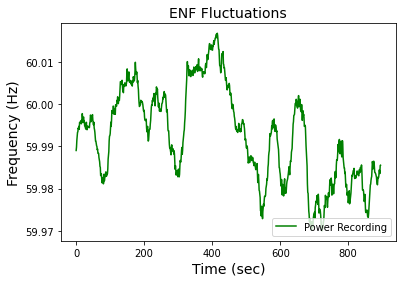

In [78]:
from os import listdir
from os.path import isfile, join
import numpy as np
import csv
import cv2
import pickle
import pyenf
import scipy.io.wavfile
import math
from scipy.fftpack import fftshift
import matplotlib.pyplot as plt
import librosa
from skimage.util import img_as_float
from skimage.segmentation import slic
from scipy.stats.stats import pearsonr

# Constants for file location

folder = "/home/pza/enf_demo/input/"
onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
power_rec_name = "power_plain_wall2.wav"
power_filepath = folder + power_rec_name

#function to compare the signal similarities

def correlation_vector(ENF_signal1, ENF_signal2, window_size, shift_size):
    correlation_ENF = []
    length_of_signal = min(len(ENF_signal1), len(ENF_signal2))
    total_windows = math.ceil(( length_of_signal - window_size + 1) / shift_size)
    rho = np.zeros((1,total_windows))
    for i in range(0,total_windows):
        enf_sig1 = ENF_signal1[i * shift_size: i * shift_size + window_size]
        enf_sig2 = ENF_signal2[i * shift_size: i * shift_size + window_size]
        enf_sig1 = np.reshape(enf_sig1, (len(enf_sig1),))
        enf_sig2 = np.reshape(enf_sig2,(len(enf_sig2), ))
        r,p = pearsonr(enf_sig1, enf_sig2)
        rho[0][i] = r
    return rho,total_windows


#parameters for the STFT algorithm

fs = 1000  # downsampling frequency
nfft = 8192
frame_size = 1#2  # change it to 6 for videos with large length recording
overlap = 0


power_signal_filename = power_filepath
power_signal0, fs = librosa.load(power_signal_filename, sr=fs)  # loading the power ENF data


#initialize the class object for the ENF. 

power_signal_object = pyenf.pyENF(signal0=power_signal0, fs=fs, nominal=60, harmonic_multiples=1, duration=0.1,
                                  strip_index=0, frame_size_secs=frame_size, nfft=nfft, overlap_amount_secs=overlap)
power_spectro_strip, power_frequency_support = power_signal_object.compute_spectrogam_strips()
power_weights = power_signal_object.compute_combining_weights_from_harmonics()
power_OurStripCell, power_initial_frequency = power_signal_object.compute_combined_spectrum(power_spectro_strip,
                                                                                            power_weights,
                                                                                            power_frequency_support)
power_ENF = power_signal_object.compute_ENF_from_combined_strip(power_OurStripCell, power_initial_frequency)

with open('full_ENF.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(power_ENF)


plt.figure()
plt.plot(power_ENF[:-10],'g', label="Power Recording")
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.xlabel('Time (sec)', fontsize=14)
plt.title('ENF Fluctuations', fontsize=14)
plt.legend(loc="lower right")
plt.show()


In [91]:
power_signal_stream = librosa.stream(power_signal_filename,block_length=10,
                                      frame_length=10000,
                                     hop_length=900)

for y in power_signal_stream:
    power_signal_object = pyenf.pyENF(signal0=y, fs=fs, nominal=60, harmonic_multiples=1, duration=0.1,
                                  strip_index=0, frame_size_secs=frame_size, nfft=nfft, overlap_amount_secs=overlap)
    power_spectro_strip, power_frequency_support = power_signal_object.compute_spectrogam_strips()
    power_weights = power_signal_object.compute_combining_weights_from_harmonics()
    power_OurStripCell, power_initial_frequency = power_signal_object.compute_combined_spectrum(power_spectro_strip,
                                                                                            power_weights,
                                                                                            power_frequency_support)
    power_ENF = power_signal_object.compute_ENF_from_combined_strip(power_OurStripCell, power_initial_frequency)

    with open('partial_ENF.csv', 'a') as f:
        write = csv.writer(f)
        write.writerows(power_ENF)

    #plt.figure()
    #plt.plot(power_ENF[:-10],'g', label="Power Recording")
    #plt.ylabel('Frequency (Hz)', fontsize=14)
    #plt.xlabel('Time (sec)', fontsize=14)
    #plt.title('ENF Fluctuations', fontsize=14)
    #plt.legend(loc="lower right")
   # plt.show()

In [74]:
from scipy.io import wavfile
fs, data = wavfile.read('/home/pza/enf_demo/input/power_plain_wall2.wav')
print(fs)

900200


In [22]:
full_data = []
partial_data = []

with open('full_ENF.csv', newline='') as f:
    reader = csv.reader(f)
    full_data = list(reader)

full_data = np.array(full_data)
full_data = full_data.astype(np.float)


with open('partial_ENF.csv', newline='') as f:
    reader = csv.reader(f)
    partial_data = list(reader)

partial_data = np.array(partial_data)
partial_data = partial_data.astype(np.float)

print(len(full_data))
print(len(full_data[:-10]))
print(len(partial_data[:-6520]))

plt.figure()
plt.plot(full_data[:-10],'g', label="Loading File at Once")
plt.plot(partial_data[:-6520],'r', label="Loading File in Real Time")
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.xlabel('Time (sec)', fontsize=14)
plt.title('ENF Fluctuations', fontsize=14)
plt.legend(loc="lower right")
plt.show()

8000


906
896
896


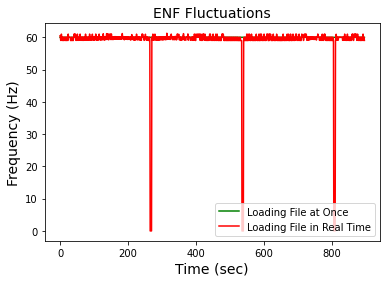